In [3]:
import cv2
bg = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/bg.jpeg')
bg = cv2.resize(bg, (1800, 1800))

image = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/test_black.jpg')
image = cv2.cvtColor(image, cv2.IMREAD_COLOR)

In [4]:
# SAME AS YOLO.PY

import os
import keras_cv
import tensorflow as tf

# Class mapping
class_ids = [
    "10c",
    "10d",
    "10h",
    "10s",
    "2c",
    "2d",
    "2h",
    "2s",
    "3c",
    "3d",
    "3h",
    "3s",
    "4c",
    "4d",
    "4h",
    "4s",
    "5c",
    "5d",
    "5h",
    "5s",
    "6c",
    "6d",
    "6h",
    "6s",
    "7c",
    "7d",
    "7h",
    "7s",
    "8c",
    "8d",
    "8h",
    "8s",
    "9c",
    "9d",
    "9h",
    "9s",
    "Ac",
    "Ad",
    "Ah",
    "As",
    "Jc",
    "Jd",
    "Jh",
    "Js",
    "Kc",
    "Kd",
    "Kh",
    "Ks",
    "Qc",
    "Qd",
    "Qh",
    "Qs",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


def create_custom_model():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xl_backbone_coco")
    yolo = keras_cv.models.YOLOV8Detector(
        num_classes=len(class_mapping),
        bounding_box_format="center_xywh",
        backbone=backbone,
        fpn_depth=1,
    )
    return yolo


def load_model():
    reconstructed_yolo = create_custom_model()
    reconstructed_yolo.load_weights("/Users/sergi/code/seeergiii/blackjack/blackjack/inference/models__20230905-0551_model_weights.h5")
    return reconstructed_yolo


def cards_prediction(image, model):
    decoded_img = tf.io.decode_image(image, channels=3, dtype=tf.dtypes.uint8)
    resized_img = tf.image.resize(decoded_img, (416, 416))
    expanded_img = tf.expand_dims(resized_img, axis=0)
    casted_img = tf.cast(expanded_img, tf.float32)

    y_pred = model.predict(casted_img)

    return y_pred

2023-09-06 18:29:53.184882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/Users/sergi/.pyenv/versions/3.10.6/envs/blackjack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load model
model = load_model()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import tensorflow as tf

def place_contours_on_bg(original_image: np.ndarray, bg_image: np.ndarray, scale_factor=1.5):
    image_resized = imutils.resize(original_image, height=1000, width=1000)
    image_greyscale = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    image_blurred = cv2.GaussianBlur(image_greyscale, (5, 5), 0)
    image_canny_kernel = cv2.Canny(image_blurred, 50, 150)
    contours, _ = cv2.findContours(image_canny_kernel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    modified_bgs = []
    clean_contours = []

    preprocessed_image_size = image_canny_kernel.shape[0] * image_canny_kernel.shape[1]
    
    for contour in contours:
        mask = np.zeros_like(image_resized)
        cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        contour_content = cv2.bitwise_and(image_resized, mask)

        # Create bounding box from contour to crop the alpha mask
        x, y, w, h = cv2.boundingRect(contour)
        
        if ((w * h)/preprocessed_image_size) > 0.01 and w/h > 0.25 and h/w > 0.25:
            clean_contours.append(contour)
            print(x, y, w, h)
            alpha_mask = mask[y:y+h, x:x+w][:,:,0] 

            # Crop only the exact shape of the contour
            cropped_content = contour_content[y:y+h, x:x+w]

            # Scale both the cropped_content and the alpha mask
            scaled_content = cv2.resize(cropped_content, None, fx=scale_factor, fy=scale_factor)
            scaled_alpha = cv2.resize(alpha_mask, None, fx=scale_factor, fy=scale_factor)

            x_offset = (bg_image.shape[1] - scaled_content.shape[1]) // 2
            y_offset = (bg_image.shape[0] - scaled_content.shape[0]) // 2

            print(x_offset, y_offset)
            
            temp_bg = bg_image.copy()

            # Convert grayscale alpha mask to 3 channel
            alpha_color = cv2.merge([scaled_alpha, scaled_alpha, scaled_alpha])

            
            # Normalize the alpha mask
            alpha_normalized = alpha_color / 255.0

            # Place the scaled contour content
            temp_bg[y_offset:y_offset+scaled_content.shape[0], x_offset:x_offset+scaled_content.shape[1]] = \
                temp_bg[y_offset:y_offset+scaled_content.shape[0], x_offset:x_offset+scaled_content.shape[1]] * \
                (1 - alpha_normalized) + scaled_content * alpha_normalized

            modified_bgs.append(temp_bg)

    print("✅ placed contours on background images")

     
    return modified_bgs, x, y, w, h, x_offset, y_offset, clean_contours, image_resized

In [7]:
example, x_orig, y_orig, w_orig, h_orig, x_offset, y_offset, contours, image_resized_re = place_contours_on_bg(image, bg, scale_factor=2)

285 658 512 602
388 298
188 56 258 359
642 541
✅ placed contours on background images


In [26]:
x_orig

188

In [24]:
len(example)

2

In [8]:
len(contours)

2

In [9]:
x_offset

642

In [10]:
def recreate_to_orig_rel(last_image, resized_img, contour, bbox, x_offset, y_offset):
    # Getting the coordinates of the cropped image inside of the resized image of Width 1000
    x, y, w, h = cv2.boundingRect(contour)
        
    # Convert to integers bbox - prediction of the model 
    center_x, center_y, w_pred, h_pred = map(int, bbox)
    
    # Convert center-xywh to top-left x,y
    top_left_x = center_x - (w_pred // 2)
    top_left_y = center_y - (h_pred // 2)
    
    print('top_left_x', top_left_x,top_left_y)
    print('offset', x_offset/1800, y_offset)
    print((center_x-x_offset))
    print((center_y-y_offset))
    
    # 416 are the dimensions of the resized image for the model
    x_rel, w_rel = top_left_x / 416, (top_left_x + w_pred) / 416
    y_rel, h_rel = top_left_y / 416, ( top_left_y + h_pred) / 416
    
    # Getting shape of the cropped image  
    last_image_shape = last_image.shape

    # Getting the relative coordinate of the card box inside of the cropped image
    x_pr = int(x_rel*last_image_shape[1])
    y_pr = int(y_rel*last_image_shape[0])
    w_pr  = int(w_rel*last_image_shape[1])
    h_pr = int(h_rel*last_image_shape[1])
    
    print(x_pr,y_pr,w_pr,h_pr)
    
    print(resized_img.shape[1])

    # Recreation of the coordinates on the rezised image to Width of 1000
    x_100width = x / resized_img.shape[1]
    w_100width = w / resized_img.shape[1]

    y_100width = y/ resized_img.shape[0]
    h_100width = h/ resized_img.shape[0]

    # Recreation of the original cordinates
    final_x = int(x_100width*image.shape[1])
    final_w= int(w_100width*image.shape[1]) +final_x

    final_y = int(y_100width*image.shape[0])
    final_h = int(h_100width*image.shape[0]) +final_y
    
    return final_x, final_y, final_w, final_h

1/1 [==============================] - 7s 7s/step
top_left_x 306 189
offset 0.3566666666666667 541
-327
-333
1324 817 1401 982
1000
top_left_x 188 305
offset 0.3566666666666667 541
-446
-219
813 1319 882 1471
1000
[array([26, 27])]
1/1 [==============================] - 1s 507ms/step
[array([26, 27]), None]


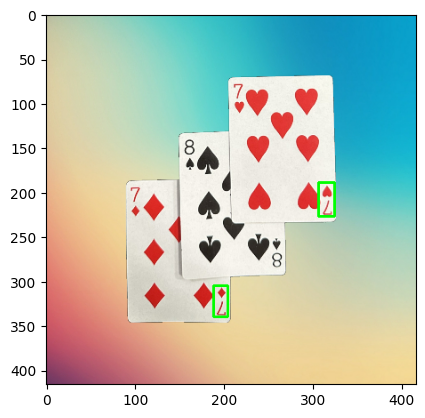

In [11]:
#from inference.interface.yolo import load_model
model = load_model()

countour_list = []
countour_index = 0

detections = []

for index, frame_cropped in enumerate(example):
    
    frame_recoded = cv2.imencode(".jpg", frame_cropped)[1].tobytes()
    decoded_img = tf.io.decode_image(frame_recoded, channels=3, dtype=tf.dtypes.uint8)
    resized_img = tf.image.resize(decoded_img, (416, 416))
    expanded_img = tf.expand_dims(resized_img, axis=0)
    casted_img = tf.cast(expanded_img, tf.float32)
    y_pred = model.predict(casted_img)
    
    #Convert TF image to Cv2 Image
    recoded = casted_img[0].numpy()
    opencv_image = recoded.astype('uint8')
    num_detections = y_pred['num_detections'][0]
    
    if num_detections > 0:
        detections.append(y_pred['classes'][0][0:num_detections])
    else:
        detections.append(None)

    boxes_in_countour_list = []
    
    for index in range(num_detections):
        bbox = y_pred['boxes'][0][index]
        countour = contours[countour_index]
        # x, y, w, h = cv2.boundingRect(countour)
        # print(x,y,w,h, 'countur')
        
        x_recreated, y_recreated, width_r, height_r = recreate_to_orig_rel(example[countour_index], image_resized_re, countour,bbox, x_offset, y_offset)
        boxes_in_countour_list.append([x_recreated, y_recreated, width_r, height_r])
        
        ########### PLOTTING THE RESULT OF THE MODEL
        # Convert to integers
        center_x, center_y, w_pred, h_pred = map(int, bbox)
        # Convert center-xywh to top-left x,y
        top_left_x = center_x - (w_pred // 2)
        top_left_y = center_y - (h_pred // 2)
        # Draw the rectangle on the image
        cv2.rectangle(opencv_image, (top_left_x, top_left_y), (top_left_x + w_pred, top_left_y + h_pred), (0, 255, 0), 2)
        plt.imshow(opencv_image)
        
        # x_rel, w_rel = top_left_x / opencv_image.shape[1], (top_left_x + w_pred) / opencv_image.shape[1]
        # y_rel, h_rel = top_left_y / opencv_image.shape[0], ( top_left_y + h_pred) / opencv_image.shape[0]
        
        ################
    countour_index+=1
    
    countour_list.append(boxes_in_countour_list)
    
    print(detections)

In [12]:
image = cv2.imread('/Users/sergi/code/seeergiii/blackjack/blackjack/inference/inference/interface/test_black.jpg')
image_recoded = cv2.imencode(".jpg", image)[1].tobytes()

In [13]:
def cards_prediction(image, model):
    decoded_img = tf.io.decode_image(image, channels=3, dtype=tf.dtypes.uint8)
    resized_img = tf.image.resize(decoded_img, (416, 416))
    expanded_img = tf.expand_dims(resized_img, axis=0)
    casted_img = tf.cast(expanded_img, tf.float32)

    y_pred = model.predict(casted_img)

    return y_pred

cards_prediction(image_recoded, model)['classes']


1/1 [==============================] - 1s 559ms/step


array([[47, 46, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1]])

In [14]:
class_mapping[46]

'Kh'

In [15]:
class_mapping[47]

'Ks'

In [16]:
y_pred['classes']

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1]])

In [17]:
num_detections

0

In [18]:
image.shape

(4032, 3024, 3)

In [19]:
x_test = int(top_left_x/416*3024)
y_test = int(top_left_y/416*4032)

w_test = int((top_left_x + w_pred)/416*3024)
h_test = int((top_left_y + h_pred)/416*4032)

In [20]:
y_test

2956

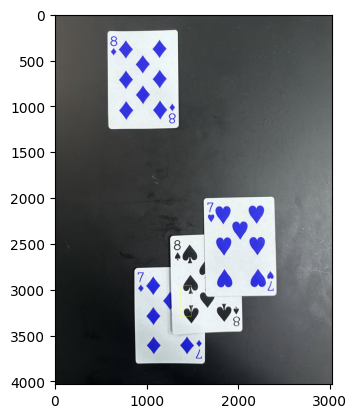

In [21]:
cv2.rectangle(image, (x_test, y_test), (w_test, h_test), (255, 255, 0), 2)
plt.imshow(image)

In [22]:
image.shape

(4032, 3024, 3)